In [ ]:
!pip install huggingface_hub
from huggingface_hub import notebook_login

In [ ]:
import argparse, itertools, math, os, random
import numpy as np, torch, torch.nn.functional as F, torch.utils.checkpoint
from torch.utils.data import Dataset, DataLoader

from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from PIL.Image import Resampling
from torchvision import transforms
from tqdm.auto import tqdm

from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer
import fastcore.all as fc
from huggingface_hub import Repository
from pathlib import Path

import torchvision.transforms.functional as tf
import accelerate

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Nome do modelo base
model_nm = "CompVis/stable-diffusion-v1-4"

# Caminho para as imagens
path = Path("/content/drive/MyDrive/desaster_samples")
paths = list(path.glob("*.jpg")) + list(path.glob("*.png"))
images = [
    Image.open(p).resize((512, 512), resample=Resampling.BICUBIC).convert("RGB")
    for p in paths
]

# Configuração do aprendizado
what_to_teach = "object"
placeholder_token = "<disaster>"
initializer_token = "landscape"

# Templates ajustados para desastres naturais
templates = [
    "a photo of a {}",
    "a dramatic photo of a {}",
    "a satellite image of a {}",
    "a photo of the aftermath of a {}",
    "a realistic photo of a {}",
    "a wide-angle photo of a {}",
    "a close-up of a {}",
    "a high-resolution photo of a {}",
    "a photo of a {} destroying a city",
    "a photo of a {} in a rural area",
    "a photo of the destruction caused by a {}",
    "a dramatic depiction of a {}",
    "a photo of a massive {}",
    "a realistic depiction of a {} in action",
    "a photo of a {} in a natural environment",
    "a satellite view of a {} impacting the land",
]

# Dataset customizado para Textual Inversion
class TextualInversionDataset:
    def __init__(self, tokenizer, images, learnable_property="object", size=512,
                 repeats=100, interpolation=Resampling.BICUBIC, flip_p=0.5, set="train", placeholder_token="*"):
        fc.store_attr()
        self.num_images = len(images)
        if set == "train":
            self._length = self.num_images * repeats
        self.templates = templates
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)

    def __len__(self):
        return self.num_images

    def __getitem__(self, i):
        image = tf.to_tensor(self.images[i % self.num_images]) * 2 - 1
        text = random.choice(self.templates).format(self.placeholder_token)
        ids = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        )
        return dict(input_ids=ids.input_ids[0], pixel_values=image)

# Tokenizer e preparação de tokens
tokenizer = CLIPTokenizer.from_pretrained(model_nm, subfolder="tokenizer")
num_added_tokens = tokenizer.add_tokens(placeholder_token)
token_ids = tokenizer.encode(initializer_token, add_special_tokens=False)
initializer_token_id = token_ids[0]
placeholder_token_id = tokenizer.convert_tokens_to_ids(placeholder_token)

# Modelos base
text_encoder = CLIPTextModel.from_pretrained(model_nm, subfolder="text_encoder").to("cuda")
vae = AutoencoderKL.from_pretrained(model_nm, subfolder="vae").to("cuda")
unet = UNet2DConditionModel.from_pretrained(model_nm, subfolder="unet").to("cuda")
text_encoder.resize_token_embeddings(len(tokenizer))
token_embeds = text_encoder.get_input_embeddings().weight.data
token_embeds[placeholder_token_id] = token_embeds[initializer_token_id]

# Congelar parâmetros
tm = text_encoder.text_model
for o in (vae, unet, tm.encoder, tm.final_layer_norm, tm.embeddings.position_embedding):
    for p in o.parameters():
        p.requires_grad = False

# Dataset de treinamento
train_dataset = TextualInversionDataset(
    images=images, tokenizer=tokenizer, size=512, placeholder_token=placeholder_token,
    repeats=100, learnable_property=what_to_teach, set="train"
)

def create_dataloader(bs=1):
    return DataLoader(train_dataset, batch_size=bs, shuffle=True)

# Agendador de ruído
noise_scheduler = DDPMScheduler(
    beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000
)

# Função de treinamento
def training_function(text_encoder, vae, unet, train_batch_size, gradient_accumulation_steps,
                      lr, max_train_steps, scale_lr, output_dir):
    accelerator = Accelerator(gradient_accumulation_steps=gradient_accumulation_steps, mixed_precision='fp16')
    train_dataloader = create_dataloader(train_batch_size)
    if scale_lr:
        lr = (lr * gradient_accumulation_steps * train_batch_size * accelerator.num_processes)
    optimizer = torch.optim.AdamW(text_encoder.get_input_embeddings().parameters(), lr=lr)
    text_encoder, optimizer, train_dataloader = accelerator.prepare(text_encoder, optimizer, train_dataloader)
    vae.to(accelerator.device).eval()
    unet.to(accelerator.device).eval()

    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)
    progress_bar = tqdm(range(max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        text_encoder.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(text_encoder):
                latents = vae.encode(batch["pixel_values"].to("cuda")).latent_dist.sample().detach() * 0.18215
                noise = torch.randn(latents.shape).to(latents.device)
                bsz = latents.shape[0]
                timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=latents.device).long()

                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
                encoder_hidden_states = text_encoder(batch["input_ids"].to("cuda"))[0]
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample
                loss = F.mse_loss(noise_pred, noise, reduction="none").mean([1, 2, 3]).mean()
                accelerator.backward(loss)

                # Apenas otimizar os embeddings
                grads = text_encoder.get_input_embeddings().weight.grad
                index_grads_to_zero = torch.arange(len(tokenizer)) != placeholder_token_id
                grads.data[index_grads_to_zero, :] = grads.data[index_grads_to_zero, :].fill_(0)
                optimizer.step()
                optimizer.zero_grad()

            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

            progress_bar.set_postfix(loss=loss.detach().item())
            if global_step >= max_train_steps:
                break

    pipeline = StableDiffusionPipeline(
        text_encoder=accelerator.unwrap_model(text_encoder),
        vae=vae, unet=unet, tokenizer=tokenizer,
        scheduler=PNDMScheduler(
            beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", skip_prk_steps=True),
        safety_checker=None,
        feature_extractor=CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32")
    )
    pipeline.save_pretrained(output_dir)
    learned_embeds = accelerator.unwrap_model(text_encoder).get_input_embeddings().weight[placeholder_token_id]
    learned_embeds_dict = {placeholder_token: learned_embeds.detach().cpu()}
    torch.save(learned_embeds_dict, os.path.join(output_dir, "learned_embeds.bin"))

# Treinamento
torch.manual_seed(42)
training_function(
    text_encoder, vae, unet, train_batch_size=1, gradient_accumulation_steps=4, lr=5e-04,
    max_train_steps=150, scale_lr=True, output_dir="sd-concept-output"
)

  0%|          | 0/150 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:221: FutureWarning: The configuration file of this scheduler: PNDMScheduler {
  "_class_name": "PNDMScheduler",
  "_diffusers_version": "0.31.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 0,
  "timestep_spacing": "leading",
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to update the config accordingly as leaving `steps_offset` might led to incorrect results in future versions. If you have downl

In [ ]:
import torch
from diffusers import StableDiffusionPipeline
from PIL import Image
from pathlib import Path

In [ ]:
torch.manual_seed(1)

def image_grid(imgs, rows=1, cols=None):
    if cols is None: cols = math.ceil(len(imgs)/rows)
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [ ]:
model_nm = "CompVis/stable-diffusion-v1-4"

output_dir="sd-concept-output"
pipe = StableDiffusionPipeline.from_pretrained(output_dir, torch_dtype=torch.float16).to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [ ]:
num_samples,num_rows = 2,2

In [ ]:
prompt = "a photo of a <tiny>."
all_images = []
for _ in range(num_rows):
    images = pipe([prompt] * num_samples, num_inference_steps=100, guidance_scale=15).images
    all_images.extend(images)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

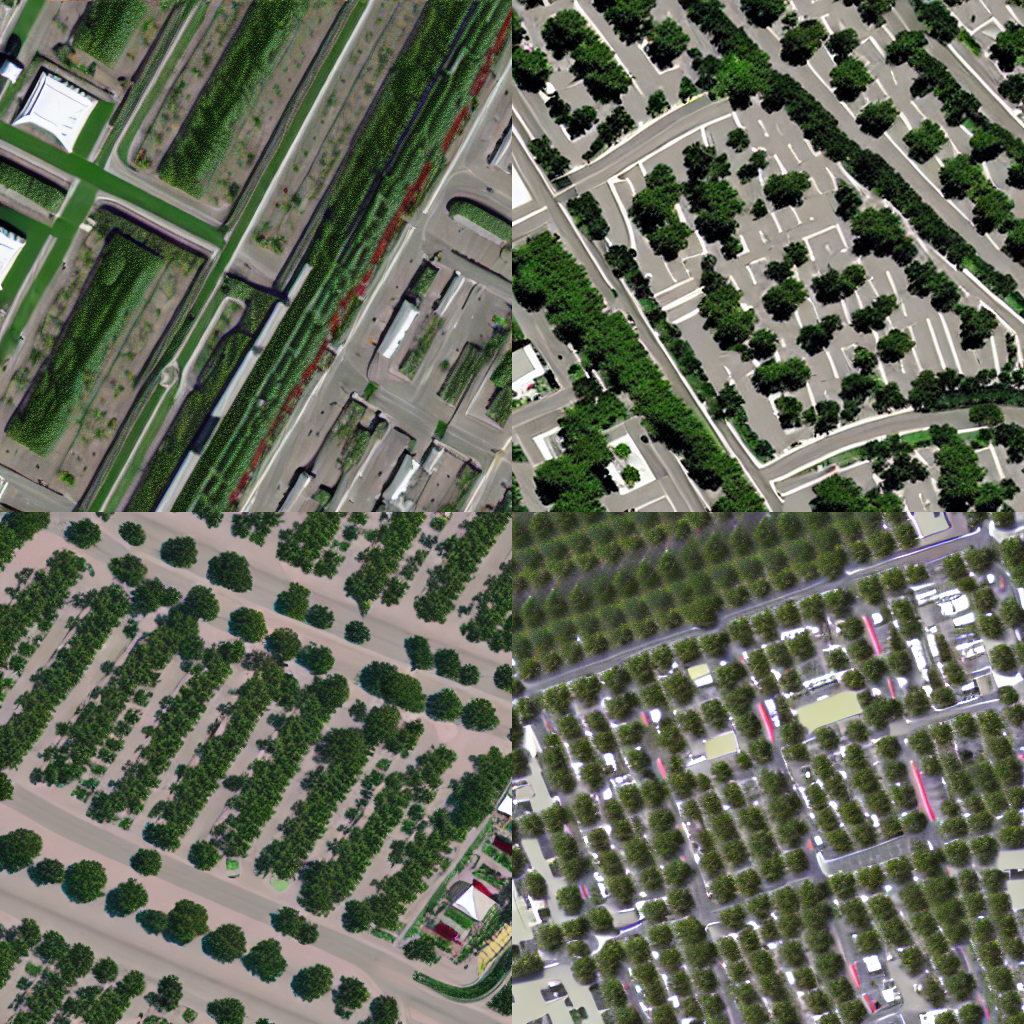

In [ ]:
image_grid(all_images, num_samples, num_rows)